In [90]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm, t, ttest_1samp, ttest_rel, ttest_ind
import matplotlib.pyplot as plt

### Population Distribution

In [2]:
# FUNCTION 1
def logit(x, position = 0.5, spread = -20, setoff = 0, altitude = 1):
    return (1/(1+np.exp(spread * (x - position)))) * altitude + setoff

# FUNCTION 2
def gauss(x, position = 0.5, deviation = 0.1, height = 0, altitude = 1):
    return (np.exp(-np.power(x - position, 2.) / (2 * np.power(deviation, 2.))) + height) * altitude

# FUNCTION 3
def winner(x, position = None):
    xPoints = np.linspace(0, 1, 5)
    yPoints = [1, 0, 0.5, 0, 1]
    h = interp1d(xPoints, yPoints)
    return h(x)

# FUNCTION 4
def sine(x, position = 0.5):
    return (np.sin(10*x + position))*0.5+0.5

functions = [logit, gauss, winner, sine]

In [3]:
def generateDistribution(function, size=1):
    if size==1:
        x = np.random.rand()
        y = function(x)
        if np.random.rand() <= y:
            return x
        return generateDistribution(function)
    else:
        return np.array([generateDistribution(function) for _ in range(size)])

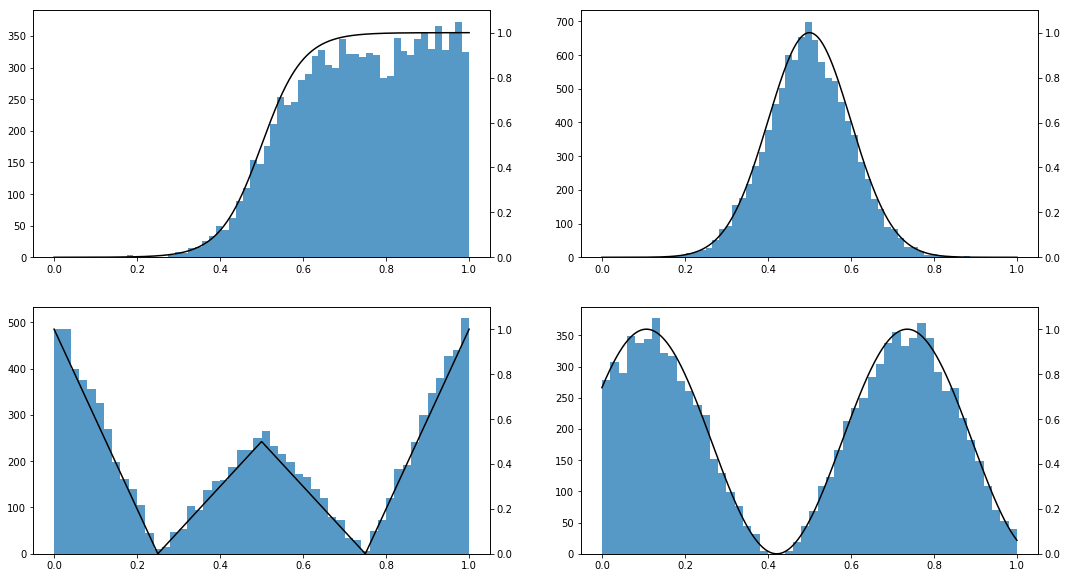

In [4]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
mean, sd = [], []
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i); ax2 = ax.twinx()
    population = generateDistribution(f, 10000)
    ax.hist(population, bins=50, alpha=0.75)
    mean.append(population.mean())
    sd.append(np.std(population))
    ax2.plot(x, f(x), '-k'); ax2.set_ylim(0,1.1)
    #ax2.fill_between(x, 0, f(x), alpha=0.2)
plt.show()

### Sampling Distribution

In [5]:
SIZE = 5
SAMPLES = 10000
ZSCORE = 1.96

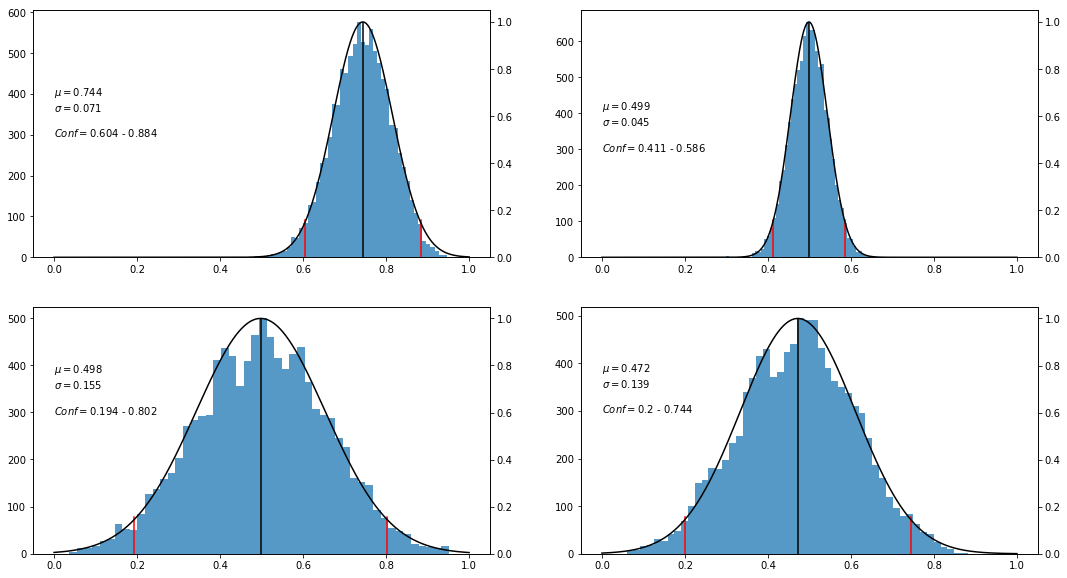

In [6]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i); ax2 = ax.twinx()
    
    samplemeans = [generateDistribution(f, SIZE).mean() for _ in range(SAMPLES)]
    se = sd[i] / np.sqrt(SIZE)
    ci = (mean[i]-ZSCORE*se, mean[i]+ZSCORE*se) # = norm.interval(0.95, mean[i], se)
    
    ax.hist(samplemeans, bins=50, alpha=0.75)
    ax2.plot(x, gauss(x, mean[i], se), '-k'); ax2.set_ylim(0,)
    ax.text(0, 300, r'$\mu =$' + str(round(mean[i], 3)) + '\n' + r'$\sigma =$' + str(round(se, 3)) +
            '\n\n' + r'$Conf = $' + str(round(ci[0], 3)) + ' - ' + str(round(ci[1], 3)))
    
    ax.axvline(x=ci[0], color='r', ymax=0.15)
    ax.axvline(x=ci[1], color='r', ymax=0.15)
    ax.axvline(x=mean[i], color='k', ymax=0.95)
plt.show()

### Z & T scores

<img src="img/z-table.jpg" style="width:530px;display:inline-block;"/>
<img src="img/t-table.jpg" style="width:370px;display:inline-block;vertical-align:top"/>

Z-scores

In [7]:
ZSCORE = 1.96
print 'Get Z-score from p-statistic: ', norm.ppf(.975)
print 'Get p-statistic from Z-score: ', norm.cdf(ZSCORE), norm.sf(ZSCORE)
print 
print 'Get CI from p-statistic: ', norm.interval(0.95)

Get Z-score from p-statistic:  1.95996398454
Get p-statistic from Z-score:  0.975002104852 0.0249978951482

Get CI from p-statistic:  (-1.959963984540054, 1.959963984540054)


P-scores

In [8]:
TSCORE = 1.65
DF = 999
print 'Get T-score from p-statistic: ', t.ppf(.95, DF)
print 'Get p-statistic from T-score: ', t.cdf(TSCORE, DF), t.sf(TSCORE, DF)
print
print 'Get CI/critical values from p-statistic: ', t.interval(0.95, DF)

Get T-score from p-statistic:  1.64638034543
Get p-statistic from T-score:  0.950371357874 0.0496286421255

Get CI/critical values from p-statistic:  (-1.9623414611334487, 1.9623414611334487)


In [351]:
def plotGauss(mu0, se, ci, mean, title):
    fig = plt.figure(figsize=(18, 5))
    x = np.linspace(mu0 - 4*se, mu0 + 4*se, num=1000)
    plt.plot(x, gauss(x, mu0, se), '-k'); plt.ylim(0,1.1)
    plt.fill_between(x, 0, gauss(x, mu0, se), alpha=0.2)
    ci1, ci2 = mu0 + ci[0] * se, mu0 + ci[1] * se
    for i in [mean, ci1, ci2]:
        plt.axvline(x=i, color='r', ymax=gauss(i, mu0, se)*0.9)
    for i in np.linspace(-3, 3, 7) * se + mu0:
        plt.axvline(x=i, color='k', ymax=gauss(i, mu0, se)*0.9)
        
    plt.text(mu0+3*se, 0.8, r'$\mu_0 =$' + str(round(mu0, 3)) + '\n' +
             r'$s_e =$' + str(round(se, 3)) + '\n' +
             r'$\overline{x}=$' + str(round(mean, 3)) + '\n' +
             r'$CI=$' + str(round(ci1, 3)) + ', ' + str(round(ci2, 3)))
    plt.title(title)
    plt.show()

### One-sampled t-test
Is there a significant difference between a sample and a given population mean.

\begin{align} 
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}\\
s &= \sqrt{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}} \\
t &= \frac{  {\overline{x} - \mu_0}}{^{S}/_{\sqrt{n-1}}}
\end{align}

In [352]:
sample = norm.rvs(loc=5.5, scale=2, size=15)
n, mean, sd = len(sample), np.mean(sample), np.std(sample)
mu0 = 6
print mean, sd
print sample

5.14903454414 1.77716536146
[ 5.35344299  5.27091351  4.22548543  4.95351442  2.43727905  5.5204203
  8.52076581  2.32593056  8.35339112  3.79571915  5.30406632  5.89039569
  6.55330306  3.0009124   5.72997835]


In [353]:
se = sd / np.sqrt(n-1)
T = (mean - mu0) / se
p = t.cdf(T, n-1)*2
ci = np.array(t.interval(.95, n-1))
print T, p, ci
print ttest_1samp(sample, mu0)

-1.79162910378 0.0948262403077 [-2.14478669  2.14478669]
Ttest_1sampResult(statistic=-1.7916291037754983, pvalue=0.094826240307654394)


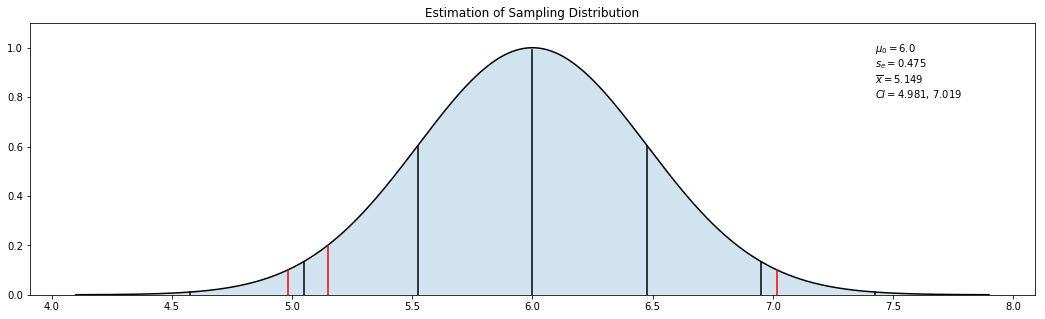

In [354]:
plotGauss(mu0, se, ci, mean, 'Estimation of Sampling Distribution')

### Paired sampled t-test
Is there a significant difference between dependent samples.

\begin{align}
x_i &= y_i - z_i\\
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}\\
s &= \sqrt{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}} \\
s_e &= \frac{s}{\sqrt{n-1}}\\
t &= \frac{  {\overline{x} - \mu_0}}{s_e}
\end{align}

In [355]:
sample1 = norm.rvs(loc=5.8, scale=2, size=15)
sample2 = norm.rvs(loc=6.1, scale=2, size=15)
sample = sample1 - sample2
n, mean, sd = len(sample), np.mean(sample), np.std(sample)
mu0 = 0 # No difference
print mean, sd
print sample

-0.800372449381 2.96059442616
[-3.57681764 -0.7523727  -1.45460668 -7.87982824  1.01232125 -4.26881387
 -3.60864155  0.46585217 -0.39905006  0.22112223  1.77606768  3.80272722
  3.31895075  0.66208361 -1.32458092]


In [357]:
se = sd / np.sqrt(n-1)
T = (mean - mu0) / se
p = t.cdf(T, n-1)*2
ci = np.array(t.interval(.95, n -1))
print T, p, ci
print ttest_rel(sample1, sample2)

-1.01152642217 0.328928257616 [-2.14478669  2.14478669]
Ttest_relResult(statistic=-1.0115264221723703, pvalue=0.3289282576162792)


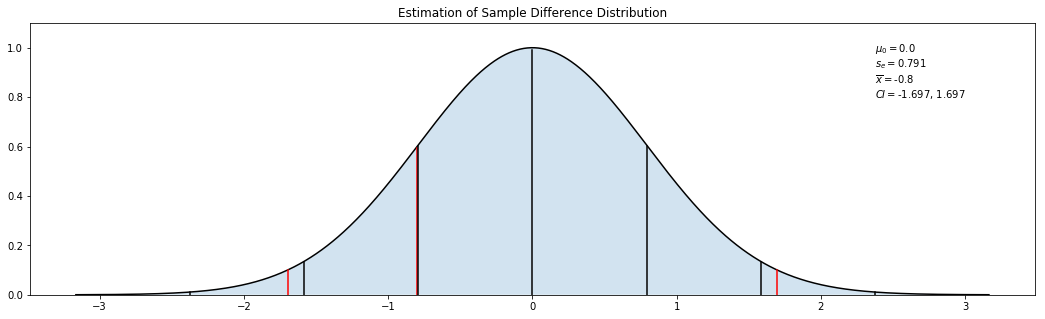

In [358]:
plotGauss(mu0, se, ci, mean, 'Estimation of Sample Difference Distribution')

### Two sample t-test
Is there a significant difference between independent samples.

\begin{align}
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}&\overline{y} &= \frac{1}{m} \sum^n_{i=1}{y_i}\\
s_x &= \sqrt{{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}}} & s_y &= \sqrt{{\frac{ \sum^m_{i=1}{(y_i - \overline{y})^2} }{m-1}}} \\
s_e &= \sqrt{\frac{(n-1)s^2_x + (m-1)s^2_y}{n+m-2} * \left(\frac{1}{n}+\frac{1}{m}\right)}\\
t &= \frac{  {\overline{x} - \overline{y}}} {s_e}
\end{align}

In [359]:
sample1 = norm.rvs(loc=5.8, scale=2, size=15)
sample2 = norm.rvs(loc=6.1, scale=2, size=10)
n, mean1, sd1 = len(sample1), np.mean(sample1), np.std(sample1)
m, mean2, sd2 = len(sample2), np.mean(sample2), np.std(sample2)
mu0 = 0
print mean1, sd1, mean2, sd2
print sample1
print sample2

5.49277274264 1.91226711223 5.83051147033 1.23334897633
[ 7.07132778  6.93515225  4.70813305  2.26940023  9.57567831  5.9486168
  6.4157807   2.87905771  7.84642163  5.36220598  4.70308321  3.20779091
  6.48082405  4.08206919  4.90604934]
[ 4.43091644  6.12210396  7.7932424   6.93894214  6.03058513  5.89217296
  5.40370785  5.70380232  3.19928918  6.79035231]


In [362]:
se = np.sqrt(((n-1) * np.power(sd1, 2) + (m-1) * np.power(sd2, 2)) / (n + m - 2) * (1/float(n)+1/float(m)))
T = (mean1 - mean2) / se
p = t.cdf(T, n+m-2)*2
ci = np.array(t.interval(.95, n + m - 2))
print T, p, ci
print ttest_ind(sample1, sample2)

-0.492547406 0.627001563106 [-2.06865761  2.06865761]
Ttest_indResult(statistic=-0.47399755860889076, pvalue=0.63997046425345494)


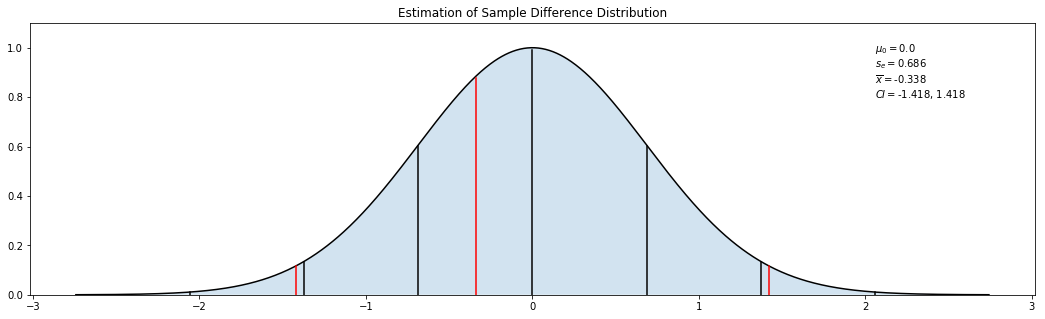

In [363]:
plotGauss(mu0, se, ci, mean1 - mean2, 'Estimation of Sample Difference Distribution')